# This code will guide you to step by step process of processing the data and running a Markov model for mutual emotion flow detection

We will use IEMOCAP database for our task. The database is available upon request from https://sail.usc.edu/iemocap/iemocap_release.htm

There are 151 dialogs, 5 sessions with different participants.

In [22]:
cd /home/sadat/kimlab/Data  

/home/sadat/kimlab/Data


In [39]:

import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt


track_session_dialog=pd.DataFrame(columns = ['session', 'dialogs','d_count', 'u_count']) #The dataframe will track and count dialog and utterances
All_utterance=pd.DataFrame()  #This dataframe will have all the utterances

for session in range(1,6): #The sessions are 1, 2, 3, 4, 5
    directory="IEMOCAP_full_release/Session"+ str(session) + "/dialog/transcriptions"
    file_List=[]
    file_List=os.listdir(directory) #It will have all the dialogs in a session 

    for dialogs in file_List:
        if dialogs.endswith(".txt"):
           f_name=directory + "/" + dialogs
           #The dataframe d1 will contain all the conversation or utterances in a dialog. It will also contain Valence and Activation,but 
            # we will add them later
           d1=pd.read_csv(f_name, sep=":", names = ["Name", "sentence", "Valence", "Activation", "Gender", "Dialog"], header=None)
           All_utterance=pd.concat([All_utterance, (d1)], ignore_index=True)
           tsd={'session':session, 'dialogs':dialogs, 'd_count': len(file_List), 'u_count': d1.shape[0]}
           track_session_dialog=track_session_dialog.append(tsd, ignore_index=True)

Now Let's Take a look at the two dataframes we produced: "All_utterance"  and "track_session_dialog"

In [40]:
All_utterance.head(5)

,Name,sentence,Valence,Activation,Gender,Dialog
0,Ses01F_impro01_F000 [006.2901-008.2357],Excuse me.,NaN,NaN,NaN,NaN
1,Ses01F_impro01_M000 [007.5712-010.4750],Do you have your forms?,NaN,NaN,NaN,NaN
2,Ses01F_impro01_F001 [010.0100-011.3925],Yeah.,NaN,NaN,NaN,NaN
3,Ses01F_impro01_M001 [010.9266-014.6649],Let me see them.,NaN,NaN,NaN,NaN
4,Ses01F_impro01_F002 [014.8872-018.0175],Is there a problem?,NaN,NaN,NaN,NaN


In [41]:
track_session_dialog.head(5)

,session,dialogs,d_count,u_count
0,1,Ses01F_impro01.txt,28,30
1,1,Ses01F_impro02.txt,28,39
2,1,Ses01F_impro03.txt,28,54
3,1,Ses01F_impro04.txt,28,72
4,1,Ses01F_impro05.txt,28,67


Great ! Now we have all the "raw" released data. We now need the ground truth. The ground truths are saved in a txt file, which can be trickier to read.

In [42]:
all_experiemnt=pd.read_csv('IEMOCAP_full_release/IEMOCAP_EmoEvaluation.txt', sep="\n")

In [43]:
all_experiemnt.head(10)

,"% [START_TIME - END_TIME] TURN_NAME EMOTION [V, A, D]"
0,[6.2901 - 8.2357]\tSes01F_impro01_F000\tneu\t[...
1,C-E2:\tNeutral;\t()
2,C-E3:\tNeutral;\t()
3,C-E4:\tNeutral;\t()
4,C-F1:\tNeutral;\t(curious)
5,A-E3:\tval 3; act 2; dom 2;\t()
6,A-E4:\tval 2; act 3; dom 3;\t(mildly aggravat...
7,A-F1:\tval 3; act 2; dom 1;\t()
8,[10.0100 - 11.3925]\tSes01F_impro01_F001\tneu\...
9,C-E2:\tNeutral;\t()


As you can see, we only need index 0, index 8 etc. in our work, because we intend to work only with dimensional labeling of the data.

In [44]:
#This is how the rows we want look like
all_experiemnt["% [START_TIME - END_TIME] TURN_NAME EMOTION [V, A, D]"][0]

'[6.2901 - 8.2357]\tSes01F_impro01_F000\tneu\t[2.5000, 2.5000, 2.5000]'

In [ ]:
"""
This bunch of code will edit the "All_Utterance" dataframe and save the parsed name (i.e., instead of Ses01F_impro01_F000 [006.2901-008.2357],
it will save only Ses01F_impro01_F000), and also save the valence and Activation labels.
"""

for i in all_experiemnt.index:
    value = all_experiemnt["% [START_TIME - END_TIME] TURN_NAME EMOTION [V, A, D]"][i]
    if "Ses" in value:
        field_splitted = value.split("\t")
        u_name = field_splitted[1]
        name_search = All_utterance["Name"].str.contains(u_name) 
        idx_name = name_search[name_search==True].index[0]
        
        #Parse gender from the uttrenaces
        name_utt = u_name
        name_reversed = name_utt[len(name_utt)::-1]
        try:
            if name_reversed[3] is 'M':
                All_utterance["Gender"][idx_name] = 'M'
            else:
                All_utterance["Gender"][idx_name] = 'F'
       
        except:
            All_utterance["Gender"][idx_name] = 'NA'   
        
        #Parse the valence and activation from utterances
        labels = re.findall(r"\d+\.\d+", field_splitted[3])
        All_utterance["Name"][idx_name] = u_name
        All_utterance["Valence"][idx_name] = float(labels[0])
        All_utterance["Activation"][idx_name] = float(labels[1])
        

In [97]:
#Great ! This is how our All_utterance look like now:
All_utterance.head(5)

,Name,sentence,Valence,Activation,Gender,Dialog
0,Ses01F_impro01_F000,Excuse me.,2.5,2.5,F,NaN
1,Ses01F_impro01_M000,Do you have your forms?,2.5,2.0,M,NaN
2,Ses01F_impro01_F001,Yeah.,2.5,2.5,F,NaN
3,Ses01F_impro01_M001,Let me see them.,2.5,2.0,M,NaN
4,Ses01F_impro01_F002,Is there a problem?,2.5,2.5,F,NaN


Now we haven't specified the dialogs yet. Good news is, we have dialogs counted in the track_session_dialog dataframe.
Let's make the full use of that 


In [98]:
 d=track_session_dialog["u_count"].to_list()    
 L=[]
 L=[i for i in d if i not in L] #Find unique numbers from u_count
 dialog_number=[]
 for i in range(1,152):
     for j in range(L[i-1]):
         dialog_number.append(i)
         
         

All_utterance['Dialog'] = dialog_number  

In [107]:
#Great ! This is how our All_utterance look like now:
All_utterance.head(10)

,level_0,index,Name,sentence,Valence,Activation,Gender,Dialog
0,0,0,Ses01F_impro01_F000,Excuse me.,2.5,2.5,F,1
1,1,1,Ses01F_impro01_M000,Do you have your forms?,2.5,2.0,M,1
2,2,2,Ses01F_impro01_F001,Yeah.,2.5,2.5,F,1
3,3,3,Ses01F_impro01_M001,Let me see them.,2.5,2.0,M,1
4,4,4,Ses01F_impro01_F002,Is there a problem?,2.5,2.5,F,1
5,5,5,Ses01F_impro01_M002,Who told you to get in this line?,2.0,3.5,M,1
6,6,6,Ses01F_impro01_F003,You did.,2.5,3.0,F,1
7,7,7,Ses01F_impro01_F004,You were standing at the beginning and you di...,2.5,3.0,F,1
8,8,8,Ses01F_impro01_M003,Okay. But I didn't tell you to get in this li...,2.5,3.5,M,1
9,9,9,Ses01F_impro01_F005,Well what's the problem? Let me change it.,2.5,3.5,F,1


Let's drop the rows having "NA" in the genbder column. These columns are basically those which donot have any data.
In a conversation, these are basically 'hmm', 'ok', 'ow', or some nodding etc.



In [101]:
search_N_A = All_utterance["Gender"].str.contains("NA")
idx_N_A = list(search_N_A[search_N_A==True].index)
All_utterance=All_utterance.drop(All_utterance.index[idx_N_A])
All_utterance=All_utterance.reset_index()
All_utterance = All_utterance.dropna()
#Things to note: we will see that after "dropna", the index are also kissing. So we need to reset them
All_utterance=All_utterance.reset_index()

#Now we will make the Turns. Remember, the turns are utterances of same speaker happening one after the other. For more details please see : https://pdfs.semanticscholar.org/4767/c5687d97b8488ad33ea96265136483ac7377.pdf

In [131]:
Turn_story = pd.DataFrame(columns = ['Turn_Name', 'Turn_Utterances', 'Gender', 
                                     'Valence', 'Activation', 'Dialog'])
L_Unames=[]
L_Valence=[]
L_Act=[]    
i = 0
var = 0
L_Unames.append(All_utterance["Name"][i])
L_Valence.append(All_utterance["Valence"][i])
L_Act.append(All_utterance["Activation"][i])
i = i+1
while i<len(All_utterance):


    if (All_utterance["Gender"][i] == All_utterance["Gender"][i-1] and
    All_utterance["Dialog"][i] == All_utterance["Dialog"][i-1]):
        L_Unames.append(All_utterance["Name"][i])
        L_Valence.append(All_utterance["Valence"][i])
        L_Act.append(All_utterance["Activation"][i])
        i = i + 1
    
    else:
        Name = "Turn_" + str(var)
        TS = {"Turn_Name":Name, 'Turn_Utterances': str(L_Unames), 'Gender':All_utterance['Gender'][i],
              'Valence':sum(L_Valence)/len(L_Valence), 'Activation': sum(L_Act)/len(L_Act),
              'Dialog':All_utterance['Dialog'][i] }
        Turn_story = Turn_story.append(TS, ignore_index=True)
        var = var + 1
        
        L_Unames=[]
        L_Valence=[]
        L_Act=[]
    
        L_Unames.append(All_utterance["Name"][i])
        L_Valence.append(All_utterance["Valence"][i])
        L_Act.append(All_utterance["Activation"][i])
        
        if i==len(All_utterance)-1:
            var = var +1
            Name = "Turn_" + var
            TS = {"Turn_Name":Name, 'Turn_Utterances': str(L_Unames), 'Gender':All_utterance['Gender'][i],
                  'Valence':sum(L_Valence)/len(L_Valence), 'Activation': sum(L_Act)/len(L_Act),
                   'Dialog':All_utterance['Dialog'][i] }
            Turn_story = Turn_story.append(TS, ignore_index=True)
            
        
        i = i+1

In [106]:
Turn_story.head(10)

,Turn_Name,Turn_Utterances,Gender,Valence,Activation,Dialog
0,Turn_0,['Ses01F_impro01_F000'],M,2.5,2.50,1
1,Turn_1,['Ses01F_impro01_M000'],F,2.5,2.00,1
2,Turn_2,['Ses01F_impro01_F001'],M,2.5,2.50,1
3,Turn_3,['Ses01F_impro01_M001'],F,2.5,2.00,1
4,Turn_4,['Ses01F_impro01_F002'],M,2.5,2.50,1
5,Turn_5,['Ses01F_impro01_M002'],F,2.0,3.50,1
6,Turn_6,"['Ses01F_impro01_F003', 'Ses01F_impro01_F004']",M,2.5,3.00,1
7,Turn_7,['Ses01F_impro01_M003'],F,2.5,3.50,1
8,Turn_8,['Ses01F_impro01_F005'],M,2.5,3.50,1
9,Turn_9,"['Ses01F_impro01_M004', 'Ses01F_impro01_M005']",F,2.0,3.75,1


Now we have a Dataframe which is for Turns. Remember, turns consist of one or more than one utterances and we took the average of the Valnece and Activation rating in the later case. Thus, it really is important to find the clusters to make it a classification problem. Here we prefer the 5 class classification: Anger, Happy, Neutral, Sad, Excitement. Details are here: https://pdfs.semanticscholar.org/4767/c5687d97b8488ad33ea96265136483ac7377.pdf

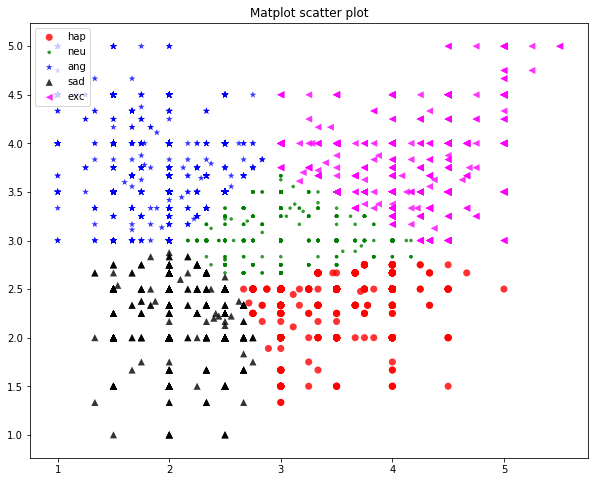

In [112]:
import matplotlib.pyplot as plt
Data = Turn_story
df = Data[['Valence', 'Activation']]

init = np.array([[3.29, 2.19],
                 [3.14, 3.15],
                 [2.21, 4.06],
                 [2.25, 1.89],
                 [3.55, 3.84]],
                np.float64)
Num = df.to_numpy()
Label = []
for i in range(len(Num)):
    x = np.argmin(np.linalg.norm(Num[i, 0:2] - init, axis=1))
    Label.append(x)
    
Turn_story["Emotion"] = Label


# Creating groups
hap = Num[[i for i, x in enumerate(Label) if x == 0]]
neu = Num[[i for i, x in enumerate(Label) if x == 1]]
ang = Num[[i for i, x in enumerate(Label) if x == 2]]
sad = Num[[i for i, x in enumerate(Label) if x == 3]]
exc = Num[[i for i, x in enumerate(Label) if x == 4]]

g0 = (hap[:, 0], hap[:, 1])
g1 = (neu[:, 0], neu[:, 1])
g2 = (ang[:, 0], ang[:, 1])
g3 = (sad[:, 0], sad[:, 1])
g4 = (exc[:, 0], exc[:, 1])

data = (g0, g1, g2, g3, g4)
colors = ("red", "green", "blue", "black", "magenta")
groups = ("hap", "neu", "ang", "sad", "exc")

# Create plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1, 1, 1)
j=0
markers = ["o", ".", "*", "^", "<"]
for data, color, group in zip(data, colors, groups):
    x, y = data
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=50, marker=markers[j], label=group)
    j=j+1

plt.title('Matplot scatter plot')
plt.legend(loc=2)
plt.show()


Now we have 151 dialogs of different utterance lengths and their emotional labels. We can use markov chains to find the mutual dependence of emotion. We will find the transition probabilities for first 120 dialogs and then we will test it for the rest 31 dialogs.

In [123]:
###########################  Markov Chain Part ###############################

First we want to find out the effect of mutual influence by markov chain

In [124]:
D=Turn_story["Dialog"].to_list()

#Train Phase
Dialog_train = max([i for i, x in enumerate(D) if x==120])
Emotions = Label[0:Dialog_train]
priors = [Emotions.count(i)/len(Emotions) for i in [0, 1, 2, 3, 4]]

#Find the conditional probabilities

trans = np.zeros((5,5)) #This is an all zero numpy array ehich will contain all the transition probabilities. Each row has
# the same source emotion and columns are of same destinaion


for j in range(5):
    finding = [i for i, x in enumerate(Emotions) if x == j]
    for f in finding:
        if (f!=len(Turn_story)-1 and Turn_story["Dialog"][f]==Turn_story["Dialog"][f+1]):
            trans[j][Turn_story["Emotion"][f+1]] =  trans[j][Turn_story["Emotion"][f+1]] + 1
    
transition_matrix = trans/np.sum(trans, 1).reshape((5,1))

 <img src="/home/sadat/Documents/markov.png">

In [126]:
transition_matrix

array([[0.2106383 , 0.25      , 0.21276596, 0.17021277, 0.15638298],
       [0.15948553, 0.27073955, 0.28488746, 0.14919614, 0.13569132],
       [0.10997305, 0.2393531 , 0.41778976, 0.19838275, 0.03450135],
       [0.1366782 , 0.19982699, 0.31747405, 0.31055363, 0.03546713],
       [0.15517241, 0.25402299, 0.07816092, 0.04482759, 0.46781609]])

In [130]:
#Test phase

from sklearn.metrics import accuracy_score, recall_score
suc = 0
Truth = []
Prediction = []
for dialog in range(121, 152):
    emotion_turns = [Label[i] for i, x in enumerate(D) if x==dialog] #Contains all the emotion of a dialog
    for j in range(len(emotion_turns)):
        Truth.append(emotion_turns[j])
        if j==0:            
            Prediction.append(priors.index(max(priors)))

        else:
            previous_emotion = emotion_turns[j-1]
            transmat_for_prev_emotion = np.argmax(transition_matrix, axis =1)
            Prediction.append(transmat_for_prev_emotion[previous_emotion])

Accuracy = accuracy_score(Truth, Prediction)
print("So The accuracy with only considering mutual influence on emotion is: " +str(Accuracy*100) + "%")
    

So The accuracy with only considering mutual influence on emotion is: 40.36363636363636%
